In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#%% import modules
import a1902alos.data_load as adl
import a1902alos.deep_mdl as adm
import os
import pandas as pd
import xarray as xr
import torch.nn as nn
from fastai import *
from fastai.vision import *

os.chdir("../data/input")




In [ ]:
#%% setup zarr data
# x_list = ["hhmean.tif", "hvmean.tif", "srtm_mean.tif", "srtm_std.tif"]
x_list = ["hhmean.tif", "hvmean.tif", "srtm_mean.tif"]
adl.get_zarr_data(
    "mask_300m.tif",
    ["lidar_training.tif"] + x_list,
    "train_300_v1.zarr",
    istarget=True,
)
adl.get_zarr_data(
    "mask.tif",
    x_list,
    "train_100_v1.zarr",
#     vmins=[0, 0, 0, 0],
#     vmaxs=[16000, 5000, 500, 11],
#     vmins=[0, 0, 0],
#     vmaxs=[16000, 5000, 500],
    istarget=False,
)

In [3]:
df = adl.get_train_df("train_300_v1.zarr", "train_300_df1")

<xarray.Dataset>
Dimensions:      (z: 414002)
Coordinates:
    y            (z) float64 -0.7629 -0.7629 -0.7629 ... -2.523 -2.523 -2.523
    x            (z) float64 18.37 18.37 18.37 18.37 ... 20.07 20.07 20.07 20.07
Dimensions without coordinates: z
Data variables:
    hhmean_0     (z) float32 dask.array<shape=(414002,), chunksize=(414002,)>
    hvmean_0     (z) float32 dask.array<shape=(414002,), chunksize=(414002,)>
    srtm_mean_0  (z) float32 dask.array<shape=(414002,), chunksize=(414002,)>
    target       (z) float32 dask.array<shape=(414002,), chunksize=(414002,)>
<xarray.Dataset>
Dimensions:      (z: 768)
Coordinates:
    y            (z) float64 -1.149 -1.152 -1.152 ... -2.321 -2.321 -2.324
    x            (z) float64 19.47 19.47 19.47 19.47 ... 19.99 19.98 19.99 19.99
Dimensions without coordinates: z
Data variables:
    hhmean_0     (z) float32 6740.2285 6718.0063 6672.6895 ... 6475.751 6506.044
    hvmean_0     (z) float32 3806.7842 3740.646 3788.3235 ... 3657.5283 3722.

MultiChannelImageList (768 items)
Image (3, 1, 1),Image (3, 1, 1),Image (3, 1, 1),Image (3, 1, 1),Image (3, 1, 1)
Path: train_100_v1.zarr@#$


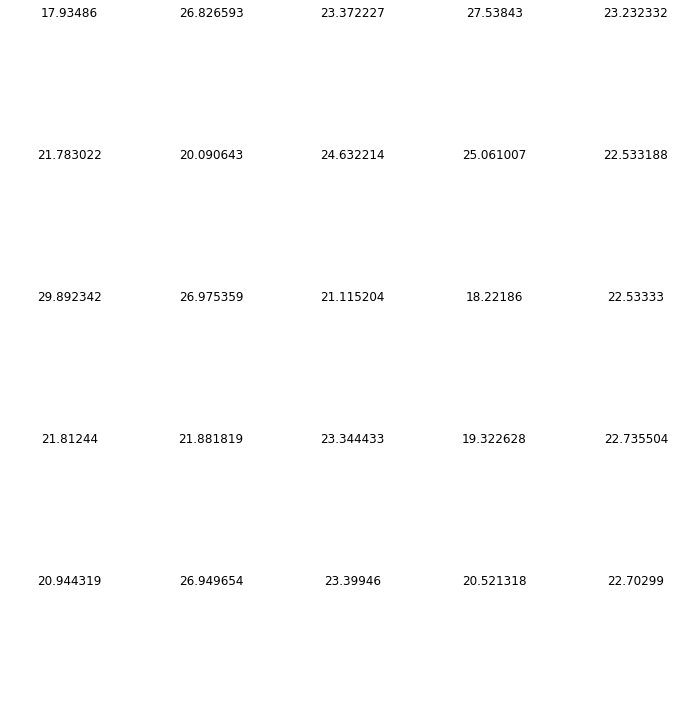

In [31]:
#%% setup databunch
df0 = pd.read_csv("train_300_df1_0.csv")
data = adl.get_databunch_from_df(
    df0, "train_100_v1.zarr", test_df=None, blocksize=(-0.0045, 0.0045), dbsize=5, bs=36,
)
data.show_batch(figsize=(10,10))


In [22]:
data.batch_stats()


[tensor([6650.5557, 3753.4873,  346.3685]),
 tensor([154.1553,  85.3891,  13.0700])]

In [32]:
data.normalize([tensor([6650.5557, 3753.4873,  346.3685]),
 tensor([154.1553,  85.3891,  13.0700])])

ImageDataBunch;

Train: LabelList (615 items)
x: MultiChannelImageList
Image (3, 5, 5),Image (3, 5, 5),Image (3, 5, 5),Image (3, 5, 5),Image (3, 5, 5)
y: FloatList
18.924294,15.815469,17.425749,20.051579,16.349012
Path: train_100_v1.zarr@#$;

Valid: LabelList (153 items)
x: MultiChannelImageList
Image (3, 5, 5),Image (3, 5, 5),Image (3, 5, 5),Image (3, 5, 5),Image (3, 5, 5)
y: FloatList
23.213589,27.549124,22.983702,24.156448,25.045761
Path: train_100_v1.zarr@#$;

Test: None

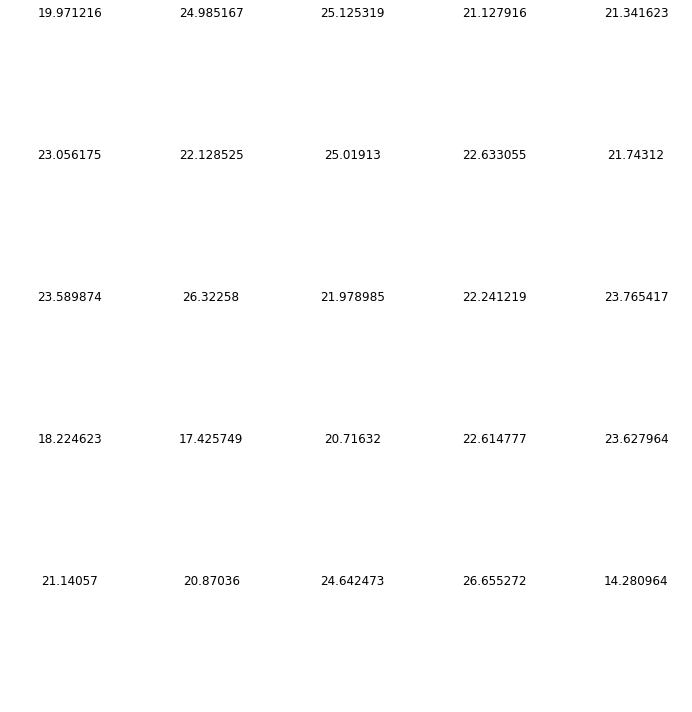

In [33]:
data.show_batch(figsize=(10,10))


In [17]:
data.items[0]

array(['train_100_v1.zarr@#$\\-1.151730199999993@#$-0.0045_0.0045',
       'train_100_v1.zarr@#$\\19.469911500000006@#$-0.0045_0.0045'], dtype='<U70')

In [23]:
#%% define model
from fastai import *

model = nn.Sequential(
    adm.conv1(3, 4),
    res_block(4),
    adm.conv2(4, 16),
    res_block(16),
    adm.conv2(16, 64),
    res_block(64),
    PoolFlatten(),
    nn.Linear(64, 1),
)

model2 = models.WideResNet(num_groups=2, N=3, num_classes=1, k=6, drop_p=0.2, n_in_channels=3)

# learn = cnn_learner(data, models.resnet18, path="../output/")
# learn = Learner(data, model, path="../output/")
# learn = Learner(data, model, loss_func = nn.MSELoss(), metrics=[mean_squared_error], path="../output/")
learn = Learner(data.normalize([tensor([0.42, 0.24, 0.02]), tensor([0.02, 0.01, 0.001])]), model2, loss_func = nn.MSELoss(), metrics=[mean_squared_error], path="../output/")

data.loss_func 


FlattenedLoss of MSELoss()

In [6]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 5, 5]           432        True      
______________________________________________________________________
BatchNorm2d          [16, 5, 5]           32         True      
______________________________________________________________________
Conv2d               [96, 5, 5]           13,824     True      
______________________________________________________________________
BatchNorm2d          [96, 5, 5]           192        True      
______________________________________________________________________
ReLU                 [96, 5, 5]           0          False     
______________________________________________________________________
Conv2d               [96, 5, 5]           82,944     True      
______________________________________________________________________
Dropout              [96, 5, 5]           0          False     
______________________________________________________________

In [24]:
#%% training
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02


0.03981071705534969

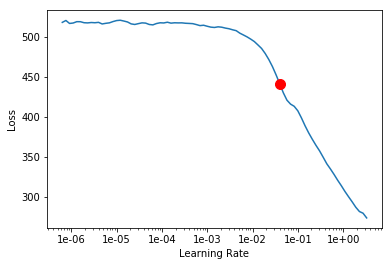

In [25]:
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr


In [26]:
learn.fit_one_cycle(30, max_lr=min_grad_lr*2)

In [10]:
learn.fit_one_cycle(30, max_lr=min_grad_lr*2)

KeyboardInterrupt: 

In [29]:
preds, y = learn.get_preds()
preds

tensor([[23.0243],
        [23.0233],
        [23.0225],
        [23.0225],
        [23.0237],
        [23.0239],
        [23.0230],
        [23.0238],
        [23.0241],
        [23.0237],
        [23.0228],
        [23.0234],
        [23.0233],
        [23.0243],
        [23.0234],
        [23.0230],
        [23.0231],
        [23.0225],
        [23.0225],
        [23.0235],
        [23.0238],
        [23.0243],
        [23.0235],
        [23.0226],
        [23.0229],
        [23.0225],
        [23.0234],
        [23.0232],
        [23.0243],
        [23.0231],
        [23.0228],
        [23.0228],
        [23.0242],
        [23.0234],
        [23.0242],
        [23.0229],
        [23.0225],
        [23.0240],
        [23.0239],
        [23.0225],
        [23.0236],
        [23.0226],
        [23.0225],
        [23.0234],
        [23.0232],
        [23.0225],
        [23.0226],
        [23.0237],
        [23.0242],
        [23.0239],
        [23.0233],
        [23.0230],
        [23.

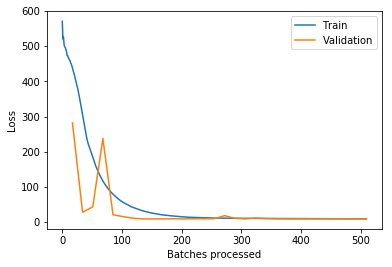

In [28]:
learn.recorder.plot_losses()

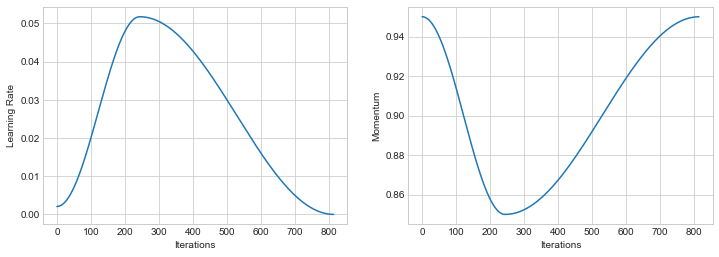

In [24]:
learn.recorder.plot_lr(show_moms=True)

In [6]:
learn.export()

In [10]:
learn = load_learner("../output")

Grid Search for pipeline of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:   13.3s finished


{'learn__max_depth': 12, 'learn__min_samples_split': 12, 'learn__n_estimators': 500, 'pca': None}
-4.765980206634762
cross-validated score: [-4.534601 -5.010124 -5.607394]
mean cv score: -5.050706327105367
(614, 1)


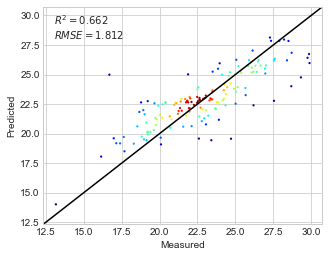

In [23]:
#%% Tabular models
import a1902alos.grid_models as gridm

y1 = df0["target"]
X1 = df0.drop(["target", 'x', 'y', 'z'], axis=1)
model_regress1 = gridm.data_train(X1, y1, outname="../output/test01_rf_plot")


In [19]:
X1 = df0.drop(["target", 'x', 'y', 'z'], axis=1)
X1

hhmean_0   hvmean_0  srtm_mean_0
0    6740.2285  3806.7842    345.15450
1    6718.0063  3740.6460    347.57640
2    6672.6895  3788.3235    343.31598
3    6726.8003  3670.2756    343.06250
4    6725.1740  3748.6597    345.03992
5    6689.5020  3771.7130    345.31467
6    6708.2285  3785.8828    342.20355
7    6678.0386  3747.3928    344.52560
8    6645.8040  3737.7112    350.09460
9    6647.9365  3800.1816    354.07553
10   6619.7970  3785.3096    345.45486
11   6662.9520  3816.1377    342.51086
12   6784.2383  3841.3643    344.01257
13   6626.6260  3754.9194    347.27518
14   6610.2686  3768.7954    350.78558
15   6590.7950  3775.7910    348.73438
16   6710.3906  3797.5234    345.72614
17   6761.9650  3796.2880    347.58203
18   6552.8022  3704.0066    353.83420
19   6627.8340  3776.7324    346.10200
20   6569.2334  3728.2656    348.97830
21   6624.3916  3763.0440    351.00912
22   6667.7754  3797.2550    355.40494
23   6576.8740  3746.3145    358.89758
24   6658.2020  3740.2354    345.69705
25   6601.0920  3730.0488    348.61676
26   6667.4014  3773.5860    350.90756
27   6764.9053  3837.4824    353.45963
28   6794.2656  3805.9980    359.28082
29   6653.2275  3787.8574    347.47656
..         ...        ...          ...
738  6791.1740  3906.0127    346.39800
739  6783.8594  3832.9287    349.16492
740  6780.9053  3788.9902    352.85590
741  6764.6543  3869.5479    352.34290
742  6701.5400  3809.4644    353.60373
743  6837.9980  3918.8867    350.55728
744  6794.9688  3841.5195    351.67883
745  6653.3730  3771.1113    352.72916
746  6806.1310  3915.6953    352.68750
747  6713.4683  3895.9744    355.18143
748  6762.1445  3861.4941    354.42535
749  6840.4270  3899.5977    355.05164
750  6731.4297  3736.4365    355.91100
751  6812.1990  3860.1797    354.44357
752  6589.5938  3850.4820    359.63022
753  6489.7646  3752.8486    359.66666
754  6465.0127  3702.0322    357.43360
755  6505.3984  3714.9727    361.89713
756  6669.3945  3822.5771    359.21960
757  6533.5590  3791.2197    357.61807
758  6224.8975  3559.6865    362.30554
759  6299.1953  3554.8623    364.72525
760  6416.6230  3546.0938    365.75607
761  6464.2970  3671.6619    364.62152
762  6465.1807  3657.9326    365.35025
763  6295.0360  3540.4917    364.60416
764  6579.9760  3744.9524    361.73135
765  6582.5835  3687.1301    368.90710
766  6475.7510  3657.5283    365.39410
767  6506.0440  3722.2540    369.21353

[768 rows x 3 columns]